VAE　オートエンコーダー

参考文献　我妻幸長　「はじめてのディープラーニング２」

In [1]:
#　colaboraory用: Google drive をマウントする
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# colaboratory用: フォルダを移る
%cd "drive/My Drive/Colab Notebooks"

/content/drive/My Drive/Colab Notebooks


フォルダは自分の指定のものに変更して下さい。

In [3]:
%cd "ctorch210929/MiniCTorch_Prototype/notebook"

/content/drive/My Drive/Colab Notebooks/ctorch210929/MiniCTorch_Prototype/notebook


ライブラリのimport

In [4]:
! pip install lark-parser

In [5]:
import sys
sys.path.append("../")

import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import minictorch.generator as GN
import minictorch.converter as CV

サンプルデータの定義

In [6]:
import torch.utils as utils
from torchvision import datasets, transforms
from sklearn import datasets

img_size = 8
n_in = img_size * img_size
n_mid = 16
n_out = n_in
n_z = 2
n_batch = 32

digits_data = datasets.load_digits()
dd = np.asarray( digits_data.data, dtype=np.float32 )
dd /= 15
x_train = torch.from_numpy( dd ).clone()
t_train = digits_data.target
print(len(x_train))

1797


サンプルデータの図化

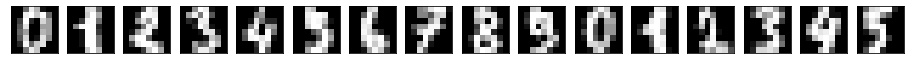

In [7]:
import matplotlib.pyplot as plt
n_img = 16

plt.figure( figsize=(16,3))
for i in range(n_img):
  ax = plt.subplot(3,n_img,i+1)
  plt.imshow(dd[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

ニューラルネットワークの定義

In [23]:
def reconstruction( y, t ):
  eps = 1.0e-7
  e = t * torch.log(y+eps) + (1-t) * torch.log(1-y+eps) 
  z = e.sum()
  #z = e.sum() / len(y)
  return -z;

def kl_divergence( mean, log_var ):
  g = 1 + log_var - mean**2 - torch.exp( log_var )
  y = 0.5 * g.sum()
  #y = 0.5 * g.sum() / len(mean)
  return -y

import torch.distributions as tdist

class Net(torch.nn.Module):
  def __init__( self, n_in, n_mid, n_out, n_z, e ):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_in, n_mid)
    #self.bn1 = nn.BatchNorm1d(n_mid)
    self.fc2_mean = nn.Linear(n_mid, n_z)
    self.fc2_var  = nn.Linear(n_mid, n_z)
    self.fc3 = nn.Linear(n_z  ,n_mid)
    self.fc4 = nn.Linear(n_mid,n_out)
    #self.drop1 = nn.Dropout(p=0.2)
    self.eps = e

    nn.init.constant_(self.fc1.bias,0)
    nn.init.constant_(self.fc2_mean.bias,0)
    nn.init.constant_(self.fc2_var.bias,0)
    nn.init.constant_(self.fc3.bias,0)
    nn.init.constant_(self.fc4.bias,0)
  
  def forward( self, x ):
    # encoder
    self.x2 = F.relu( self.fc1(x) )
    #self.x1 = F.relu( self.fc1(x) )
    #self.x2 = self.bn1( self.x1 )
    self.mean    = self.fc2_mean( self.x2 )
    self.log_var = self.fc2_var( self.x2 )

    # reparametrization
    #eps = torch.randn( n_batch, n_z )
    eps = torch.randn( self.mean.shape )
    #nm = tdist.Normal( 0.0, 1.0 )
    #eps = nm.sample([ n_batch, n_z ])
    #eps = torch.normal(0.0,1.0,[32,2])
    #print("eps",eps)
    self.z = self.mean + eps * torch.exp( 0.5 * self.log_var )
    #self.z = self.mean + self.eps * torch.exp( 0.5 * self.log_var )

    # decoder
    y = F.relu( self.fc3( self.z ) )
    #y = self.drop1( self.y )
    y = torch.sigmoid( self.fc4( y ) )
    self.out = y 
    
    #e1 = reconstruction( y, x )
    e1 = F.binary_cross_entropy( y , x, reduction="sum" )
    e2 = kl_divergence( self.mean, self.log_var )

    self.loss1 = e1
    self.loss2 = e2
    return (e1+e2)

計算グラフをJSONファイルに出力する

In [24]:
def generate_json( json_path, input, e ):

    model = Net( n_in, n_mid, n_out, n_z, e )

    model.eval()
    with torch.no_grad():
        print("[SAVE]", json_path )
        GN.generate_minictorch_file( model, input, json_path )

    return model

In [25]:
torch.manual_seed( 1 )

project = 'vae1'
json_path = './network/' + project +'.json'

x = x_train.clone().detach()
torch.reshape( x, (-1,n_in) )

x = x[0:n_batch,:]
#print(type(x))
#x.requires_grad = True

e = torch.randn( n_batch, 2 )
#print("eps",e)

model = generate_json( json_path, x, e )

torch.Size([32, 64])
[SAVE] ./network/vae1.json
skip: Net/Linear[fc1]/weight/fc1
skip: Net/Linear[fc1]/weight/fc1
skip: Net/Linear[fc2_mean]/weight/fc2_mean
skip: Net/Linear[fc2_mean]/weight/fc2_mean
skip: Net/Linear[fc2_var]/weight/fc2_var
skip: Net/Linear[fc2_var]/weight/fc2_var
skip: Net/Linear[fc3]/weight/fc3
skip: Net/Linear[fc3]/weight/fc3
skip: Net/Linear[fc4]/weight/fc4
skip: Net/Linear[fc4]/weight/fc4


/usr/local/lib/python3.7/dist-packages/torch/jit/_trace.py:991: TracerWarning: Trace had nondeterministic nodes. Did you forget call .eval() on your model? Nodes:
	%eps : Float(32, 2, strides=[2, 1], requires_grad=0, device=cpu) = aten::randn(%41, %42, %43, %44, %45) # <ipython-input-23-52b26810c2af>:44:0
This may cause errors in trace checking. To disable trace checking, pass check_trace=False to torch.jit.trace()
  _module_class,
/usr/local/lib/python3.7/dist-packages/torch/jit/_trace.py:991: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Scalars are not close!

Absolute difference: 7.2154541015625 (up to 1e-05 allowed)
Relative difference: 0.005048024080618078 (up to 1e-05 allowed)
  _module_class,


一回の順伝播、逆伝播のC++コードを生成する

In [26]:
folder = "./vae"
CV.convert_cpp_code( project, folder, model, x, json_path )

[JSON] ./network/vae1.json
{'name': 'Net/Linear[fc1]/weight/weight.11', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 1}
{'name': 'Net/Linear[fc1]/bias/bias.11', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 2}
{'name': 'Net/Linear[fc2_mean]/weight/weight.13', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 5}
{'name': 'Net/Linear[fc2_mean]/bias/bias.13', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 6}
{'name': 'Net/Linear[fc2_var]/weight/weight.15', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [24], 'sorted_id': 22}
{'name': 'Net/Linear[fc2_var]/bias/bias.15', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [24], 'sorted_id': 23}
{'name': 'Net/Linear[fc3]/weight/weight.17', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [33], 'sorted_id': 31}
{'name': 'Net/Li

In [27]:
# check code
with torch.set_grad_enabled(True):
  model.eval()
  output = model( x )
  print("output",output)
  output.backward()
  print("input_grad",x.grad)

output tensor(1428.0906, grad_fn=<AddBackward0>)
input_grad None


C++コードをコンパイル、リンクする

In [28]:
!g++ -std=c++14 ./vae/vae1.cpp ./vae/vae1_param.cpp -D_NOTEBOOK -I ../../../xtensor -lcblas -o ./vae/vae1

(注意) xtensorフォルダにxtensor関連のincludeファイルを置いています。各自の環境に合わせて変更して下さい。

In [29]:
!./vae/vae1

### forward computation ...
{ 1423.829834}
### backward computation ...
input_grad{{-0.082754, -0.062344, -0.007766, ...,  0.008542, -0.052853,  0.011956},
 {-0.028702, -0.033319, -0.007702, ...,  0.003688, -0.001269,  0.028357},
 {-0.250287, -0.223156,  0.007111, ...,  0.05431 , -0.109969,  0.106161},
 ..., 
 { 0.002704, -0.010902, -0.001357, ..., -0.015014, -0.010815,  0.014793},
 {-0.085785,  0.000741,  0.026928, ...,  0.041416,  0.007625,  0.076885},
 {-0.109081, -0.015153,  0.039404, ...,  0.051356, -0.000163,  0.160405}}


学習ループの実行 (python版)

In [43]:
torch.manual_seed( 1 )

epochs = 200
batch_size = 32
#interval = 5  # 経過の表示間隔

e = torch.randn( batch_size, 2 )
#print("eps",e)

net = Net( n_in, n_mid, n_out, n_z, e )
net.train()

lr = 0.001
type=1
if type==1:
  opt = torch.optim.SGD(net.parameters(), lr)
  #opt = torch.optim.Adagrad(net.parameters(), lr)
if type==2:
  lr = 0.001
  opt = torch.optim.Adam(net.parameters(), lr )

epoch_loss1 = []
epoch_loss2 = []

rec_error_record = []
reg_error_record = []
total_error_record = []
n_batchs = len(x_train) // batch_size  # 1エポックあたりのバッチ数
print("batch",n_batch,len(x_train),batch_size)

for i in range(epochs):
        
    # -- 学習 -- 
    index_random = np.arange(len(x_train))
    np.random.shuffle(index_random)  # インデックスをシャッフルする

    total_loss = 0.0
    for j in range(n_batchs):
        
        # ミニバッチを取り出す
        mb_index = index_random[ j*batch_size : (j+1)*batch_size ]
        x_mb = x_train[mb_index, :]
        #x_mb.requires_grad = True
        #print("x?mb",x_mb.shape)
        
        # 順伝播と逆伝播
        loss = net( x_mb )
        #print("loss",loss)
        #print("z",j,net.z)
        total_loss += loss;

        opt.zero_grad()
        loss.backward()
        #forward_propagation(x_mb)
        #backpropagation(x_mb)
        
        # 重みとバイアスの更新
        opt.step()
        #print("EPOCH: {} {} loss: {}".format(i,j, loss))
        #epoch_loss.append( loss )
        #update_params()

    # -- 誤差を求める --
    print("EPOCH: {} loss: {}".format(i, total_loss))
    #epoch_loss.append( total_loss )

    x2 = x_train.clone().detach()
    torch.reshape( x2, (-1,n_in) )
    #print(x2.shape)

    net.eval()

    #net.eps = torch.randn( len(x_train), 2 )

    loss = net( x2 )
    print("loss",loss,net.loss1,net.loss2)
    #print("out shape", net.out.shape)
    #print("out",net.out)
    if type==1:
      epoch_loss1.append( loss )
    if type==2:
      epoch_loss2.append( loss )

batch 32 1797 32
EPOCH: 0 loss: 59456.7890625
loss tensor(51884.3555, grad_fn=<AddBackward0>) tensor(49398.6094, grad_fn=<BinaryCrossEntropyBackward0>) tensor(2485.7446, grad_fn=<NegBackward0>)
EPOCH: 1 loss: 51109.5390625
loss tensor(50741.5234, grad_fn=<AddBackward0>) tensor(48811.8633, grad_fn=<BinaryCrossEntropyBackward0>) tensor(1929.6609, grad_fn=<NegBackward0>)
EPOCH: 2 loss: 50323.69921875
loss tensor(50112.1328, grad_fn=<AddBackward0>) tensor(48849.3047, grad_fn=<BinaryCrossEntropyBackward0>) tensor(1262.8273, grad_fn=<NegBackward0>)
EPOCH: 3 loss: 49747.4140625
loss tensor(49610.9062, grad_fn=<AddBackward0>) tensor(48567.1758, grad_fn=<BinaryCrossEntropyBackward0>) tensor(1043.7323, grad_fn=<NegBackward0>)
EPOCH: 4 loss: 49037.23046875
loss tensor(48634.6797, grad_fn=<AddBackward0>) tensor(47061.5703, grad_fn=<BinaryCrossEntropyBackward0>) tensor(1573.1090, grad_fn=<NegBackward0>)
EPOCH: 5 loss: 48163.5703125
loss tensor(47917.6406, grad_fn=<AddBackward0>) tensor(46272.3906, 

収束状況グラフを描画する

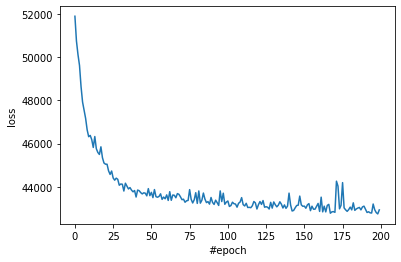

In [44]:
fig = plt.figure()
ax = fig.add_subplot()
if type==1:
  ax.plot(list(range(len(epoch_loss1))), epoch_loss1)
if type==2:
  ax.plot(list(range(len(epoch_loss2))), epoch_loss2)
ax.set_xlabel('#epoch')
ax.set_ylabel('loss')
fig.show()

生成された画像を描画する

O (1797, 64)


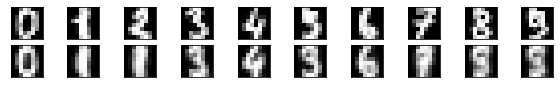

In [45]:
n_img2=10
x2 = x_train.clone().detach()
x3=x2[:n_img2]

torch.reshape( x2, (-1,n_in) )

loss = net( x2 )

o = net.out.to('cpu').detach().numpy().copy()
print("O",o.shape)

plt.figure( figsize=(10,2) )
for i in range(n_img2):
  #input image
  ax = plt.subplot(3,n_img2,i+1)
  plt.imshow( x3[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  #output image
  ax = plt.subplot(3,n_img2,i+1+n_img2)
  plt.imshow( o[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

潜在変数の空間を描画する

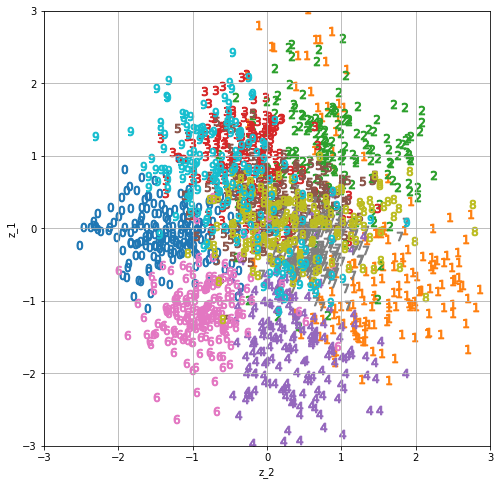

In [46]:
t2 = t_train #[:n_batch]

x2 = x_train.clone().detach()
torch.reshape( x2, (-1,n_in) )
loss = net( x2 )

plt.figure(figsize=(8,8))
for i in range(10):
  zt = net.z[t2==i]
  z_1 = zt[:,0]
  z_2 = zt[:,1]
  marker= "$"+str(i)+"$"
  plt.scatter(z_2.tolist(), z_1.tolist(), marker=marker,s=75)

plt.xlabel("z_2")
plt.ylabel("z_1")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.grid()
plt.show()

潜在変数を変化させたときの画像を描画する

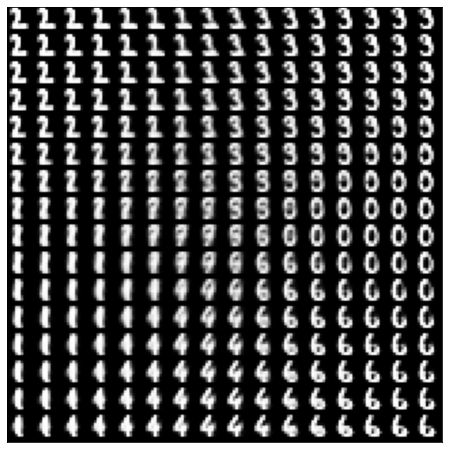

In [47]:
n_img3=16
img_size_spaced = img_size + 2
matrix_image = np.zeros(( img_size_spaced*n_img3, img_size_spaced*n_img3 ))

z_1 = np.linspace( 3, -3, n_img3 )
z_2 = np.linspace( 3, -3, n_img3 )

with torch.set_grad_enabled(False):
  for i, z1 in enumerate(z_1):
    for j,z2 in enumerate(z_2):

      z = np.array([z1, z2])
      zz = torch.from_numpy( z ).float()
      
      y = F.relu( net.fc3(zz) )
      o = torch.sigmoid( net.fc4(y) )
      image = o.reshape(img_size, img_size)
      top  = i * img_size_spaced
      left = j * img_size_spaced
      matrix_image[top:top+img_size, left:left+img_size] = image

plt.figure(figsize=(8,8))
plt.imshow( matrix_image.tolist(), cmap="Greys_r" )
plt.tick_params( labelbottom=False, labelleft=False, bottom=False, left=False )
plt.show()

学習用データファイル、学習ループのC++コードを生成する

In [30]:
CV.convert_data_file( project, folder, inp_data=dd )
CV.convert_train_code( project, folder, json_path, sol="vae", z="fc3", epochs=200, batch=32, lr=0.001, inp_data=dd )

datafile key :  inp_data
param: inp_data  - str loop  5000  /  14375
param: inp_data  - str loop  10000  /  14375
[DATA] ./vae/vae1_data.cpp
[JSON] ./network/vae1.json
epoch_num :  200
batch_size :  32
lr :  0.001
inp shape (1797, 64) 2
inp  shape :  1 {1797,64}
pred shape :  0 
target shape :  0 
div :  False
nb,nk :  41 56
batch_size: 32
inp_shape: {1797,64}
bce_no :  41
unpack0 aten::sigmoid
unpack original no:  38 38
vae z:  30  keyw: fc3
[TRAIN]  ./vae/vae1_train.cpp


学習用C++コードをコンパイル、リンクする

In [33]:
!g++ -std=c++14 ./vae/vae1.cpp ./vae/vae1_param.cpp ./vae/vae1_data.cpp ./vae/vae1_train.cpp -D_NOTEBOOK -D_TRAIN -I ../../../xtensor -lcblas -o ./vae/vae1_train

In [35]:
!./vae/vae1_train

epoch_num : 200
indata shape   : 1797,64
batch  number  : 56,32
learning ratio : 0.001
total_loss : epoch 0 - loss 60041
epoch 0 - loss 52061.6 ( 50030 , 2031.65 ) 
total_loss : epoch 1 - loss 51067.2
epoch 1 - loss 50526 ( 48822.8 , 1703.12 ) 
total_loss : epoch 2 - loss 50241.1
epoch 2 - loss 49905.7 ( 48561.5 , 1344.26 ) 
total_loss : epoch 3 - loss 49416.4
epoch 3 - loss 49069.3 ( 47382.5 , 1686.8 ) 
total_loss : epoch 4 - loss 48637.4
epoch 4 - loss 48312 ( 46417.8 , 1894.17 ) 
total_loss : epoch 5 - loss 48081
epoch 5 - loss 48113.3 ( 46502.2 , 1611.14 ) 
total_loss : epoch 6 - loss 47574
epoch 6 - loss 47531.3 ( 45927.5 , 1603.8 ) 
total_loss : epoch 7 - loss 47188.4
epoch 7 - loss 47204.5 ( 45550.7 , 1653.77 ) 
total_loss : epoch 8 - loss 46820
epoch 8 - loss 46772.7 ( 44932.9 , 1839.85 ) 
total_loss : epoch 9 - loss 46392.2
epoch 9 - loss 46266.3 ( 44142.4 , 2123.9 ) 
total_loss : epoch 10 - loss 46194.8
epoch 10 - loss 46078.5 ( 43794.9 , 2283.58 ) 
total_loss : epoch 11 - lo

c++ からの出力ファイルの読み込み

In [36]:
#load out file
f = open('./vae/vae1.out', 'r')

epoch_loss = []
datalist = f.readlines()
for data in datalist:
  epoch_loss.append( float(data) )
f.close()

print("epoch =", len(epoch_loss))
print( epoch_loss)

# load pred file
f2 = open('./vae/vae1.pred', 'r')

datalist = f2.readlines()

n1 = 10
n2 = 64
k = 0
for data in datalist:
  ds = data.split(',')
  if k==0:
    n1 = int(ds[0])
    n2 = int(ds[1])
    global v_pred
    v_pred = np.zeros( (n1,n2))
  else:
    for i in range(n2):
      v_pred[k-1,i] = float(ds[i])
  k = k+1

f2.close()

print("pred =", n1,n2 )
#print( y_pred )

# load z file
f3 = open('./src/vae1.z', 'r')

datalist = f3.readlines()
n1 = 100
n2 = 2
k = 0
for data in datalist:
  ds = data.split(',')
  if k==0:
    nz1 = int(ds[0])
    nz2 = int(ds[1])
    z_pred = np.zeros( (nz1,nz2))
  else:
    z_pred[k-1,0] = float(ds[0])
    z_pred[k-1,1] = float(ds[1])
  k = k+1

f3.close()

print("z =", nz1,nz2 )
#print(z_pred)

epoch = 200
[52061.632812, 50525.960938, 49905.726562, 49069.308594, 48311.988281, 48113.300781, 47531.257812, 47204.492188, 46772.726562, 46266.289062, 46078.460938, 45913.851562, 46149.328125, 45722.078125, 45530.980469, 45565.535156, 45554.265625, 45842.464844, 45347.9375, 45155.96875, 45353.011719, 45302.605469, 44808.9375, 44662.902344, 44785.265625, 44440.589844, 44561.164062, 44249.210938, 44207.410156, 44026.375, 44029.4375, 44073.421875, 44033.5, 43870.441406, 43934.046875, 43827.0625, 43909.125, 43752.113281, 43928.230469, 43727.484375, 44018.878906, 43791.632812, 43774.917969, 43742.003906, 43575.160156, 43826.480469, 43655.570312, 43876.023438, 43571.285156, 43772.003906, 43585.28125, 43720.515625, 43523.980469, 43478.800781, 43703.332031, 43699.621094, 43606.824219, 43618.625, 43353.136719, 43486.839844, 43572.921875, 43595.328125, 43529.054688, 43669.207031, 43483.957031, 43470.996094, 43503.6875, 43362.859375, 43322.410156, 43441.152344, 43406.707031, 43492.648438, 43306

収束状況グラフを描画する

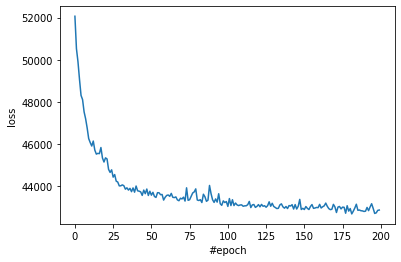

In [37]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('#epoch')
ax.set_ylabel('loss')
fig.show()

生成された画像を描画する

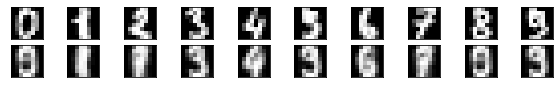

In [38]:
n_img5 = 10
x2 = x[:n_img5]

plt.figure( figsize=(10,2))
for i in range(n_img5):
  # input image
  ax = plt.subplot(3,n_img5,i+1)
  plt.imshow( x2[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # output image
  ax = plt.subplot(3,n_img5,i+1+n_img5)
  plt.imshow( v_pred[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

潜在変数の空間を描画する

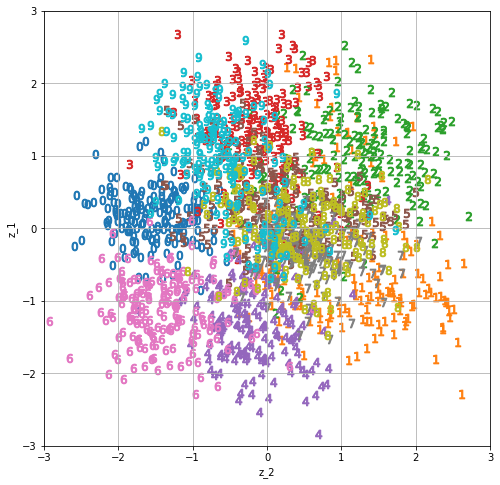

In [39]:
t2 = t_train #[:n_batch]

plt.figure(figsize=(8,8))
for i in range(10):
  zt = z_pred[t2==i]
  z_1 = zt[:,0]
  z_2 = zt[:,1]
  marker= "$"+str(i)+"$"
  plt.scatter( z_2.tolist(),  z_1.tolist(), marker=marker,s=75 )

plt.xlabel("z_2")
plt.ylabel("z_1")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.grid()
plt.show()

In [ ]:
# yet 
n_img3=16
img_size_spaced = img_size + 2
matrix_image = np.zeros(( img_size_spaced*n_img3, img_size_spaced*n_img3 ))

z_1 = np.linspace( 3, -3, n_img3 )
z_2 = np.linspace( 3, -3, n_img3 )

with torch.set_grad_enabled(False):
  for i, z1 in enumerate(z_1):
    for j,z2 in enumerate(z_2):

      z = np.array([z1, z2])
      zz = torch.from_numpy( z ).float()
      
      y = F.relu( net.fc3(zz) )
      o = torch.sigmoid( net.fc4(y) )
      image = o.reshape(img_size, img_size)
      top  = i * img_size_spaced
      left = j * img_size_spaced
      matrix_image[top:top+img_size, left:left+img_size] = image

plt.figure(figsize=(8,8))
plt.imshow( matrix_image.tolist(), cmap="Greys_r" )
plt.tick_params( labelbottom=False, labelleft=False, bottom=False, left=False )
plt.show()